In [1]:
import numpy as np

import repeated_play

import axelrod as axl

In [2]:
import pandas as pd

In [3]:
pd.set_option('display.max_columns', None)  

In [4]:
import itertools

from axelrod.action import Action

C, D = Action.C, Action.D

In [5]:
from tqdm.notebook import tqdm

In [6]:
import matplotlib.pyplot as plt

In [7]:
import networkx as nx

In [8]:
from collections import Counter

In [9]:
from scipy import stats

In [10]:
def match_payoffs(player, coplayer, Sx, Sy, memory="one"):
    M = repeated_play.transition_matrix_repeated_game(
        player, coplayer, memory=memory
    )

    ss = repeated_play.stationary_distribution(M)[0]

    return ss, ss @ Sx, ss @ Sy

In [11]:
def reactive_two_t_memory_two(strategy):
    return (strategy[0], strategy[1], strategy[0], strategy[1],
            strategy[2], strategy[3], strategy[2], strategy[3],
            strategy[0], strategy[1], strategy[0], strategy[1],
            strategy[2], strategy[3], strategy[2], strategy[3]
           )

In [12]:
player = [0.99, 0.1, 0.6, 0.3]

prime_player = [0.99, 0.6, 0.1, 0.3]

In [13]:
player_mem2 = reactive_two_t_memory_two(player)

In [14]:
prime_player_mem2 = reactive_two_t_memory_two(prime_player)

In [15]:
b, c = 1, 1/2

Sx = np.array([b - c, -c, b, 0] * 4)

Sy = np.array([b - c, b, -c, 0] * 4)

In [16]:
ss, payoff, _ = match_payoffs(player_mem2, player_mem2, Sx, Sy, memory="two")

In [17]:
ss2, payoff2, _ = match_payoffs(prime_player_mem2, prime_player_mem2, Sx, Sy, memory="two")

# Simulations

In [18]:
class Mem2Transformed(axl.MemoryTwoPlayer):
    
    
    def __init__(self, sixteen_vector) -> None:
        super().__init__(sixteen_vector)
        
    def strategy(self, opponent):
        """Actual strategy definition that determines player's action."""
        turn = len(self.history)
        if turn <= 1:
            return self._random.random_choice(0.5)

        p = self._sixteen_vector[
            ((self.history[-2], opponent.history[-2]), (self.history[-1], opponent.history[-1]))
        ]

        return self._random.random_choice(p)
#         except AttributeError:
#             return C if p == 1 else D

In [19]:
donation = axl.game.Game(r=b-c, s=-c, t=b, p=0)

### Player

In [20]:
reps = 20

In [21]:
scores, results_player = [], []

for _ in tqdm(range(reps)):
    
    p1 = Mem2Transformed(player_mem2)
    
    p2 = Mem2Transformed(player_mem2)
    
    match = axl.Match([p1, p2], turns=10**6, game=donation)
    
    _ = match.play()
    
    score = match.final_score_per_turn()[0]
    
    scores.append(score)
    
    results_player.append(match.result)

  0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
results_flatten = [x for xs in results_player for x in xs]

states_player = {history: 0 for history in  itertools.product([C, D], repeat=4)}

for i, hist in enumerate(results_flatten[:-1]):
    states_player[hist + results_flatten[i + 1]] += 1 / (10 ** 6 * reps)

In [23]:
scores2, results_prime_player = [], []

for _ in tqdm(range(reps)):
    
    p1 = Mem2Transformed(prime_player_mem2)
    
    p2 = Mem2Transformed(prime_player_mem2)
    
    match = axl.Match([p1, p2], turns=10**6, game=donation)
    
    _ = match.play()
    
    score = match.final_score_per_turn()[0]
    
    scores2.append(score)
    
    results_prime_player.append(match.result)

  0%|          | 0/20 [00:00<?, ?it/s]

In [24]:
results_flatten2 = [x for xs in results_prime_player for x in xs]

states_prime_player = {history: 0 for history in  itertools.product([C, D], repeat=4)}

for i, hist in enumerate(results_flatten2[:-1]):
    states_prime_player[hist + results_flatten2[i + 1]] += 1 / (10 ** 6 * reps)

/var/folders/19/1t7slkb13h578dr5bl_47kf80000gp/T/ipykernel_27057/3249340034.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[letter].set_xticklabels(['' for _ in range(16)],);


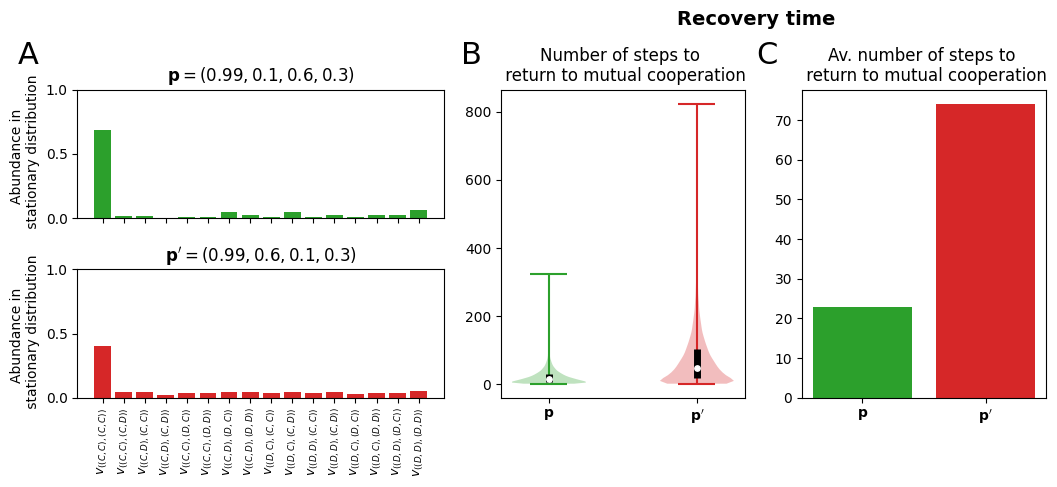

In [43]:
fig, axes = plt.subplot_mosaic("ABE;CBE", figsize=(12.5, 4),
                               gridspec_kw = {'height_ratios':[1, 1], 'width_ratios': [1.5, 1, 1],
                                              'hspace': 0.4})

# Markov chain process
axes["A"].bar(range(1, 17), ss, color='tab:green');

axes["C"].bar(range(1, 17), ss2, color='tab:red');


# ticks and stuff

for letter in ['A', "C",]:

    axes[letter].set_ylim(0, 1)

    axes[letter].set_yticks(np.arange(0, 1.1, .5));

    axes[letter].set_xticks(np.arange(1, 17, 1));

for letter in ['C']:

    axes[letter].set_xticklabels(['$v_{((C, C), (C, C))}$',
                               '$v_{((C, C), (C, D))}$',
                               '$v_{((C, D), (C, C))}$',
                               '$v_{((C, D), (C, D))}$',
                               '$v_{((C, C), (D, C))}$',
                               '$v_{((C, C), (D, D))}$',
                               '$v_{((C, D), (D, C))}$',
                               '$v_{((C, D), (D, D))}$',
                               '$v_{((D, C), (C, C))}$',
                               '$v_{((D, C), (C, D))}$',
                               '$v_{((D, D), (C, C))}$',
                               '$v_{((D, D), (C, D))}$',
                               '$v_{((D, C), (D, C))}$',
                               '$v_{((D, C), (D, D))}$',
                               '$v_{((D, D), (D, C))}$',
                               '$v_{((D, D), (D, D))}$'], rotation=90, fontsize=9
                         );

    axes[letter].xaxis.set_tick_params(labelbottom=True)
    
    
for letter in ['A', 'B']:

    axes[letter].set_xticklabels(['' for _ in range(16)],);

    
axes['A'].set_title("$\mathbf{p}=(0.99, 0.1, 0.6, 0.3)$");

axes['C'].set_title(r"$\mathbf{p'}=(0.99, 0.6, 0.1, 0.3)$");


violioplots = axes["B"].violinplot([[len(cycle) for cycle in cycles], 
                                    [len(cycle) for cycle in cycles_prime]],
                                   showmeans=False, showmedians=False,
                                   showextrema=True);


data = [[len(cycle) for cycle in cycles],
        [len(cycle) for cycle in cycles_prime]]

quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)

inds = np.arange(1, len(medians) + 1)

axes["B"].scatter(inds, medians, marker='o', color='white', s=15, zorder=3)
axes["B"].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)


for pc, color in zip(violioplots['bodies'], ['tab:green', 'tab:red']):
    pc.set_facecolor(color)

for partname in ('cbars','cmins','cmaxes'):
    violioplots[partname].set_colors(['tab:green', 'tab:red'])


axes["E"].bar([0, 1],
              [np.mean([len(cycle) for cycle in cycles]),
               np.mean([len(cycle) for cycle in cycles_prime])],
               color=['tab:green', 'tab:red']);

axes["E"].set_xticks([0, 1], ["$\mathbf{p}$", r"$\mathbf{p'}$"]);

axes["B"].set_xticks([1, 2], ["$\mathbf{p}$", r"$\mathbf{p'}$"]);

axes["B"].set_title("Number of steps to \n return to mutual cooperation");

axes["E"].set_title("Av. number of steps to \n return to mutual cooperation");
axes["E"].text(-1.5, 94, "Recovery time", fontweight='bold', fontsize=14)


axes["A"].text(-3, 1.2, "A", fontsize="22");
axes["A"].set_ylabel("Abundance in \n stationary distribution");
axes["C"].set_ylabel("Abundance in \n stationary distribution");
axes["A"].text(18, 1.2, "B", fontsize="22");
axes["A"].text(32, 1.2, "C", fontsize="22");

fig.savefig("../figures/siFigReactiveTwoPayoffs.pdf", bbox_inches="tight")

## New Cycles Analysis by CH comments

In [26]:
states_to_letters = {(C, C): "A", (C, D): "B", (D, C): "C", (D, D): "D"}

letters_to_states = {"A": (C, C), "B": (C, D), "C": (D, C), "D": (D, D)}

In [27]:
class Mem2TransformedWithOpening(axl.MemoryTwoPlayer):
    
    
    def __init__(self, opening, sixteen_vector) -> None:
        super().__init__(sixteen_vector)
        self.opening = opening
        
    def strategy(self, opponent):
        """Actual strategy definition that determines player's action."""
        turn = len(self.history)
        if turn == 0:
            return self.opening[0]
        if turn == 1:
            return self.opening[1]

        p = self._sixteen_vector[
            ((self.history[-2], opponent.history[-2]), (self.history[-1], opponent.history[-1]))
        ]

        return self._random.random_choice(p)


In [28]:
p1_prime = Mem2TransformedWithOpening(opening=[C, C], sixteen_vector=prime_player_mem2)

p2_prime = Mem2TransformedWithOpening(opening=[C, D], sixteen_vector=prime_player_mem2)

In [29]:
cycles_prime = []
histories_prime = []

for i in tqdm(range(5 * 10 ** 4)):
    match = axl.Match([p1_prime, p2_prime], turns=1000, seed=i)
    _ = match.play()
    
    actions = []
    histories = []

    for action_before, action_now in zip(match.result[1:], match.result[2:]):
        actions.append(action_now)
        histories.append((action_before, action_now))
        

        if action_before == (C, C) and action_now == (C, C):
            break
            
    cycles_prime.append(actions)
    histories_prime.append(histories)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [30]:
np.mean([len(cycle) for cycle in cycles_prime])

73.97498

In [31]:
[i for i, cycle in enumerate(cycles_prime) if len(cycle) > 900]

[]

In [32]:
np.mean([len(history) for history in histories_prime])

73.97498

In [36]:
cycles_in_letters_prime = ["".join([states_to_letters[history] for history in cycle]) for cycle in cycles_prime]

In [37]:
len(cycles_in_letters_prime)

50000

In [35]:
counter_prime = Counter(cycles_in_letters)

NameError: name 'cycles_in_letters' is not defined

In [ ]:
counter_prime.most_common(15)

In [38]:
p1 = Mem2TransformedWithOpening(opening=[C, C], sixteen_vector=player_mem2)

p2 = Mem2TransformedWithOpening(opening=[C, D], sixteen_vector=player_mem2)

In [39]:
cycles = []
histories_player = []

for i in tqdm(range(5 * 10 ** 4)):
    match = axl.Match([p1, p2], turns=710, seed=i)
    _ = match.play()
    
    actions = []
    histories = []

    for action_before, action_now in zip(match.result[1:], match.result[2:]):
        actions.append(action_now)
        histories.append((action_before, action_now))

        if action_before == (C, C) and action_now == (C, C):
            break
            
    cycles.append(actions)
    histories_player.append(histories)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [40]:
np.mean([len(cycle) for cycle in cycles])

22.95732

In [41]:
[i for i, cycle in enumerate(cycles) if len(cycle) > 700]

[]

In [42]:
cycles_in_letters = ["".join([states_to_letters[history] for history in cycle]) for cycle in cycles]

In [ ]:
counter = Counter(cycles_in_letters)

In [ ]:
len(counter.keys())

In [ ]:
len(counter_prime.keys())

In [ ]:
cycles_in_letters_prime = ["".join([states_to_letters[history] for history in cycle]) for cycle in cycles_prime]

In [ ]:
cycles_in_letters = ["".join([states_to_letters[history] for history in cycle]) for cycle in cycles]

In [ ]:
len(cycles_in_letters_prime), len(cycles_in_letters)

In [ ]:
prime_set = set([len(cycle) for cycle in cycles_in_letters_prime])

In [ ]:
normal_set = set([len(cycle) for cycle in cycles_in_letters])

In [ ]:
most_common = Counter(cycles_in_letters)

In [ ]:
len(list(set(cycles_in_letters)))

In [ ]:
len(most_common.keys())

In [ ]:
most_common_prime = Counter(cycles_in_letters_prime)

In [ ]:
len(most_common_prime.keys())

In [ ]:
len(list(set(cycles_in_letters_prime)))

## The table

In [924]:
player = most_common.most_common(15)

In [925]:
most_common_letters = [hist[0] for hist in player]

In [926]:
[i for i, hist in enumerate(cycles_in_letters) if most_common_letters[0] == hist][0]

3

In [927]:
most_common_histories = [[letters_to_states[letter] for letter in history[0]] for history in player]

In [928]:
length = [len(history) for history in most_common_histories]

In [929]:
frequency = [f"{round((history[1] / (5 * 10 ** 4)) * 100, 1)}%" for history in player]

In [933]:
[round((history[1] / (5 * 10 ** 4)) * 100, 1) for history in player]

[5.9, 3.0, 1.8, 1.0, 0.9, 0.6, 0.6, 0.5, 0.5, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3]

In [904]:
player_one_rows = []
player_two_rows = []

for hist in most_common_histories:
    player_one = ''
    player_two = ''
    for actions in hist:
        player_one += f'{actions[0]}'
        player_two += f'{actions[1]}'
        
    player_one_rows.append(player_one)
    player_two_rows.append(player_two)

In [905]:
table = pd.DataFrame([player_one_rows, player_two_rows, length, frequency]).T

In [906]:
table.index = range(1, 16)

In [907]:
table

,0,1,2,3
1,CC,CC,2,5.9%
2,DCC,CCC,3,3.0%
3,DCCC,CDCC,4,1.8%
4,DCDCC,CDCCC,5,1.0%
5,DDDCC,CDCCC,5,0.9%
6,DDCC,CCCC,4,0.6%
7,DDDCC,CDDCC,5,0.6%
8,DCDCCC,CDDDCC,6,0.5%
9,DCDCCC,CDCDCC,6,0.5%
10,DDDDCC,CDDCCC,6,0.4%


In [908]:
print(table.to_latex())

\begin{tabular}{lllll}
\toprule
{} &        0 &        1 &  2 &     3 \\
\midrule
1  &       CC &       CC &  2 &  5.9\% \\
2  &      DCC &      CCC &  3 &  3.0\% \\
3  &     DCCC &     CDCC &  4 &  1.8\% \\
4  &    DCDCC &    CDCCC &  5 &  1.0\% \\
5  &    DDDCC &    CDCCC &  5 &  0.9\% \\
6  &     DDCC &     CCCC &  4 &  0.6\% \\
7  &    DDDCC &    CDDCC &  5 &  0.6\% \\
8  &   DCDCCC &   CDDDCC &  6 &  0.5\% \\
9  &   DCDCCC &   CDCDCC &  6 &  0.5\% \\
10 &   DDDDCC &   CDDCCC &  6 &  0.4\% \\
11 &   DDDCCC &   CDDDCC &  6 &  0.4\% \\
12 &   DCDDCC &   CDDDCC &  6 &  0.4\% \\
13 &     DDCC &     CDCC &  4 &  0.3\% \\
14 &   DDDDCC &   CDDDCC &  6 &  0.3\% \\
15 &  DCDCDCC &  CDCDCCC &  7 &  0.3\% \\
\bottomrule
\end{tabular}



/var/folders/19/1t7slkb13h578dr5bl_47kf80000gp/T/ipykernel_46755/3293683267.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


In [911]:
probs

[0.396,
 0.04000000000000001,
 0.04000000000000001,
 0.04000000000000001,
 0.06,
 0.099]

In [912]:
len( most_common_histories)

15

In [913]:
probabilities_to_paths = []


for most_common_history in most_common_histories:

    solve = [(C, C), (C, D)] + most_common_history


    probs = []

    for two_rounds_ago, one_round_ago, reaction in zip(solve, solve[1:], solve[2:]):
        history = (two_rounds_ago, one_round_ago)
        reversed_history = tuple([t[::-1] for t in history])

        if reaction[0] == C:
            player_one = p1._sixteen_vector[history]
        elif reaction[0] == D:
            player_one = 1 - p1._sixteen_vector[history]

        if reaction[1] == C:
            player_two = p2._sixteen_vector[reversed_history]
        elif reaction[1] == D:
            player_two = 1 - p2._sixteen_vector[reversed_history]

        probs.append(player_one * player_two)
        
    probabilities_to_paths.append(round(np.prod(probs), 4))
    

In [914]:
probabilities_to_paths

[0.0588,
 0.0318,
 0.0171,
 0.0093,
 0.0093,
 0.0063,
 0.0065,
 0.005,
 0.005,
 0.0045,
 0.0045,
 0.0035,
 0.0035,
 0.0032,
 0.0027]

In [915]:
np.prod(probs)

0.002700165840134401

In [916]:
prime = most_common_prime.most_common(15)

In [917]:
most_common_letters = [hist[0] for hist in prime]

In [918]:
most_common_histories = [[letters_to_states[letter] for letter in history[0]] for history in prime]

In [919]:
length = [len(history) for history in most_common_histories]

In [920]:
frequency = [f"{round((history[1] / (5 * 10 ** 4)) * 100, 1)}%" for history in prime]

In [923]:
sum([round((history[1] / (5 * 10 ** 4)) * 100, 1) for history in prime])

14.499999999999998

In [862]:
player_one_rows = []
player_two_rows = []

for hist in most_common_histories:
    player_one = ''
    player_two = ''
    for actions in hist:
        player_one += f'{actions[0]}'
        player_two += f'{actions[1]}'
        
    player_one_rows.append(player_one)
    player_two_rows.append(player_two)

In [863]:
table = pd.DataFrame([player_one_rows, player_two_rows, length, frequency]).T

In [864]:
table.index = range(1, 16)

In [865]:
table

,0,1,2,3
1,CC,CC,2,5.9%
2,CDCC,CCCC,4,3.2%
3,CDCCCC,CCCDCC,6,1.6%
4,CDCCCDCC,CCCDCCCC,8,0.9%
5,DDCC,CCCC,4,0.6%
6,CDCCCDCCCC,CCCDCCCDCC,10,0.4%
7,DDCCCC,CCCDCC,6,0.3%
8,CDCCCC,CCDDCC,6,0.3%
9,DDCCCC,CCDDCC,6,0.2%
10,DCC,CCC,3,0.2%


In [866]:
print(table.to_latex())

\begin{tabular}{lllll}
\toprule
{} &             0 &             1 &   2 &     3 \\
\midrule
1  &            CC &            CC &   2 &  5.9\% \\
2  &          CDCC &          CCCC &   4 &  3.2\% \\
3  &        CDCCCC &        CCCDCC &   6 &  1.6\% \\
4  &      CDCCCDCC &      CCCDCCCC &   8 &  0.9\% \\
5  &          DDCC &          CCCC &   4 &  0.6\% \\
6  &    CDCCCDCCCC &    CCCDCCCDCC &  10 &  0.4\% \\
7  &        DDCCCC &        CCCDCC &   6 &  0.3\% \\
8  &        CDCCCC &        CCDDCC &   6 &  0.3\% \\
9  &        DDCCCC &        CCDDCC &   6 &  0.2\% \\
10 &           DCC &           CCC &   3 &  0.2\% \\
11 &  CDCCCDCCCDCC &  CCCDCCCDCCCC &  12 &  0.2\% \\
12 &      CDCCCDCC &      CCDDCCCC &   8 &  0.2\% \\
13 &      CDCCDDCC &      CCCDCCCC &   8 &  0.2\% \\
14 &      DDCCCDCC &      CCCDCCCC &   8 &  0.2\% \\
15 &         DCCCC &         CCDCC &   5 &  0.1\% \\
\bottomrule
\end{tabular}



/var/folders/19/1t7slkb13h578dr5bl_47kf80000gp/T/ipykernel_46755/3293683267.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


In [867]:
probabilities_to_paths = []


for most_common_history in most_common_histories:

    solve = [(C, C), (C, D)] + most_common_history


    probs = []

    for two_rounds_ago, one_round_ago, reaction in zip(solve, solve[1:], solve[2:]):
        history = (two_rounds_ago, one_round_ago)
        reversed_history = tuple([t[::-1] for t in history])

        if reaction[0] == C:
            player_one = p1_prime._sixteen_vector[history]
        elif reaction[0] == D:
            player_one = 1 - p1_prime._sixteen_vector[history]

        if reaction[1] == C:
            player_two = p2_prime._sixteen_vector[reversed_history]
        elif reaction[1] == D:
            player_two = 1 - p2_prime._sixteen_vector[reversed_history]

        probs.append(player_one * player_two)
        
    probabilities_to_paths.append(round(np.prod(probs), 4))
    

In [868]:
probabilities_to_paths

[0.0588,
 0.0311,
 0.0165,
 0.0087,
 0.0063,
 0.0046,
 0.0033,
 0.0033,
 0.0024,
 0.0024,
 0.0024,
 0.0018,
 0.0018,
 0.0018,
 0.0012]

# Cycles

Let's transform the histories to letters. More specifically,

- (C, C) -> A
- (C, D) -> B
- (D, C) -> C
- (D, D) -> D

In [569]:
states_to_letters = {(C, C): "A", (C, D): "B", (D, C): "C", (D, D): "D"}

In [570]:
results_player_letters = [[states_to_letters[state] for state in states] 
                          for states in results_player]

Let's write the function for getting cycles

In [571]:
def get_cycles(result):

    overall_cycles = []

    source = ["A", "A"]

    current_cycle = []

    cycle_happening = False

    for i, turn in enumerate(result[:-1]):

        state = [turn, result[i + 1]]

        if state == source and cycle_happening == False:
            cycle_happening = True

            current_cycle = [state]

        elif state == source and len(current_cycle) == 1:
            assert cycle_happening == True
            current_cycle = [state]


        elif state == source and len(current_cycle) > 1:
            assert cycle_happening == True

            current_cycle.append(state)
            overall_cycles.append(current_cycle)

            current_cycle = []
            cycle_happening = False


        elif state != source and cycle_happening == True:
            assert cycle_happening == True
            current_cycle.append(state)
        else:
            pass
    return overall_cycles

Let's test it.

In [572]:
result = ["A", "A", "A"]

get_cycles(result)

[]

In [573]:
result = ["A", "A", "B", "D"]

get_cycles(result)

[]

In [574]:
result = ["A", "A", "B", "D", "A", "A", "C", "D",]

get_cycles(result)

[[['A', 'A'], ['A', 'B'], ['B', 'D'], ['D', 'A'], ['A', 'A']]]

In [575]:
result = ["A", "A", "B", "D", "A", "A", "C", "D", "A", "A", "B", "D",]

get_cycles(result)

[[['A', 'A'], ['A', 'B'], ['B', 'D'], ['D', 'A'], ['A', 'A']]]

In [576]:
result = ["A", "A", "B", "D", "A", "A", "C", "D", "A", "A", "B", "D", "A", "A",]

get_cycles(result)

[[['A', 'A'], ['A', 'B'], ['B', 'D'], ['D', 'A'], ['A', 'A']],
 [['A', 'A'], ['A', 'B'], ['B', 'D'], ['D', 'A'], ['A', 'A']]]

Let's transform both results.

In [577]:
results_prime_player_letters = [[states_to_letters[state] for state in states] 
                          for states in results_prime_player]

Let's get the cycles.

In [578]:
cycles_player = []

for result in results_player_letters:
    cycles = get_cycles(result)
    cycles_player.append(cycles)

In [579]:
# [len(cycle) for cycle in cycles_player]

In [580]:
sum([len(cycle) for cycle in cycles_player])

268563

In [581]:
flatten_cycles_player = [x for xs in cycles_player for x in xs]

In [582]:
np.mean([len(cycle) for cycle in flatten_cycles_player])

24.822946571195587

Let's get the cycles for prime player.

In [583]:
cycles_prime_player = []

for result in results_prime_player_letters:
    cycles = get_cycles(result)
    cycles_prime_player.append(cycles)

In [584]:
sum([len(cycle) for cycle in cycles_prime_player])

158347

In [585]:
flatten_cycles_prime_player = [x for xs in cycles_prime_player for x in xs]

In [586]:
np.mean([len(cycle) for cycle in flatten_cycles_prime_player])

75.36901235893323

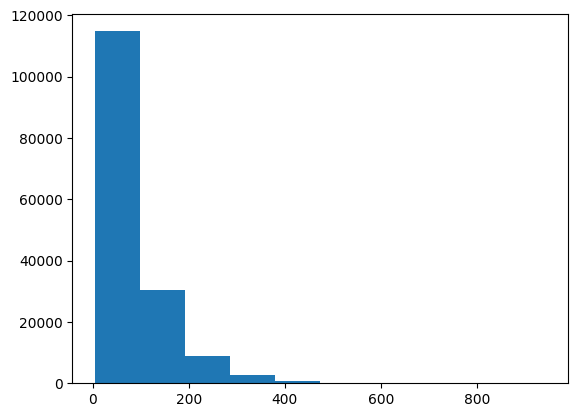

In [587]:
plt.hist([len(cycle) for cycle in flatten_cycles_prime_player]);

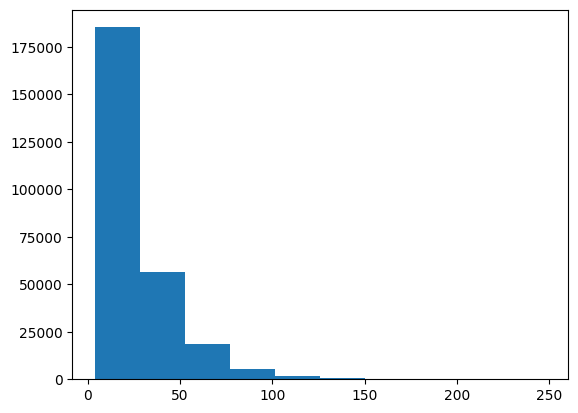

In [588]:
plt.hist([len(cycle) for cycle in flatten_cycles_player]);

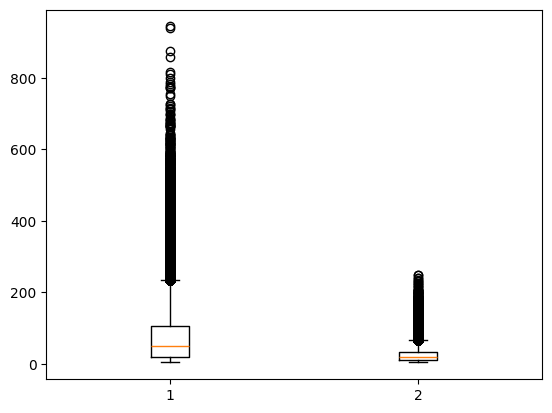

In [589]:
plt.boxplot([[len(cycle) for cycle in flatten_cycles_prime_player],
            [len(cycle) for cycle in flatten_cycles_player]]);


In [590]:
c = Counter([len(cycle) for cycle in flatten_cycles_prime_player])

In [591]:
c.most_common(5)

[(4, 9235), (6, 6035), (8, 4300), (10, 3460), (12, 2707)]

In [592]:
c = Counter([len(cycle) for cycle in flatten_cycles_player])

In [593]:
c.most_common(5)

[(4, 15563), (8, 10521), (7, 10009), (9, 9952), (10, 9689)]

Let's write it as sequence so we can find duplicates and the most common cycles.

In [594]:
sequences_player = []

for cycle in flatten_cycles_player:

    sequence = "-".join(["".join(state) for state in cycle])
    
    sequences_player.append(sequence)

In [595]:
len(sequences_player)

268563

In [596]:
count = Counter(sequences_player)

In [597]:
count.most_common(15)

[('AA-AC-CA-AA', 7868),
 ('AA-AB-BA-AA', 7688),
 ('AA-AB-BC-CA-AA', 4292),
 ('AA-AC-CB-BA-AA', 4165),
 ('AA-AC-CB-BC-CA-AA', 2274),
 ('AA-AB-BC-CB-BA-AA', 2247),
 ('AA-AC-CB-BD-DB-BA-AA', 1257),
 ('AA-AB-BC-CD-DC-CA-AA', 1252),
 ('AA-AC-CB-BC-CB-BA-AA', 1241),
 ('AA-AB-BC-CB-BC-CA-AA', 1231),
 ('AA-AB-BC-CD-DD-DA-AA', 921),
 ('AA-AC-CB-BD-DD-DA-AA', 893),
 ('AA-AC-CB-BB-BA-AA', 825),
 ('AA-AB-BC-CC-CA-AA', 816),
 ('AA-AC-CB-BC-CD-DC-CA-AA', 701)]

In [602]:
len(count.keys())

171291

In [603]:
len(sequences_player)

268563

In [610]:
'AA-AC' == sequences_player[0][:5]

False

In [611]:
sequences_where_AC_happends = [seq for seq in sequences_player if seq[:5] == 'AA-AC']

In [612]:
len(sequences_where_AC_happends)

133914

In [613]:
(7935 / len(sequences_where_AC_happends)) * 100

5.925444688382096

In [80]:
(4204  / len(sequences_player)) * 100

1.5663422703766077

In [81]:
(2275 / len(sequences_player)) * 100

0.8476281315667893

In [92]:
sequences_prime_player = []

for cycle in flatten_cycles_prime_player:

    sequence = "-".join(["".join(state) for state in cycle])
    
    sequences_prime_player.append(sequence)

In [93]:
len(sequences_prime_player)

158095

In [94]:
count_prime = Counter(sequences_prime_player)

In [95]:
count_prime.most_common(15)

[('AA-AC-CA-AA', 4643),
 ('AA-AB-BA-AA', 4553),
 ('AA-AC-CA-AB-BA-AA', 2450),
 ('AA-AB-BA-AC-CA-AA', 2425),
 ('AA-AC-CA-AB-BA-AC-CA-AA', 1296),
 ('AA-AB-BA-AC-CA-AB-BA-AA', 1272),
 ('AA-AC-CA-AB-BA-AC-CA-AB-BA-AA', 687),
 ('AA-AB-BA-AC-CA-AB-BA-AC-CA-AA', 676),
 ('AA-AC-CB-BB-BA-AA', 535),
 ('AA-AB-BC-CC-CA-AA', 523),
 ('AA-AB-BA-AC-CA-AB-BA-AC-CA-AB-BA-AA', 373),
 ('AA-AC-CA-AB-BA-AC-CA-AB-BA-AC-CA-AA', 369),
 ('AA-AB-BC-CC-CA-AB-BA-AA', 273),
 ('AA-AC-CA-AB-BC-CC-CA-AA', 254),
 ('AA-AC-CB-BB-BA-AC-CA-AA', 253)]

In [936]:
5.9 + 3.2 + 1.6 + .9 + .6 + .4 + .3 + .3 + .2 + .2 + .2 +.2 + .2 + .2 + .1

14.499999999999998

In [97]:
(2425 / len(sequences_prime_player)) * 100

1.5338878522407413

In [98]:
(1272 / len(sequences_prime_player)) * 100

0.8045795249691641